In [1]:
import os
import ast
import json
from glob import glob
from collections import Counter
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import networkx as nx
from modules.load_data import load

In [54]:
metadata_core = pd.read_csv('../raw/metadata_kwd_list_vocab7000.csv')
metadata = load('metadata')
metadata_core.columns, metadata_core.shape

In [55]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,post_id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [25]:
# 문자열 형태로 저장된 리스트를 리스트로 인식되도록 복구
def str2list(strlist: str) -> list:
    listed = ast.literal_eval(strlist)
    return listed

metadata_core['keyword_list'] = metadata_core['keyword_list'].apply(lambda x: str2list(x))

In [39]:
# 태그별 빈도 파악
def squeeze(arr: list) -> list:
    '''2차원 리스트를 1차원으로 squeeze'''
    result = []
    for l in arr:
        if len(l) > 0 and isinstance(l, list):
            result.extend(l)
        elif not isinstance(l, list):
            result.append(l)
    return result

kwd_counts = pd.Series(squeeze(metadata_core['keyword_list'].tolist())).value_counts()
vocab7000 = kwd_counts.index.tolist() 

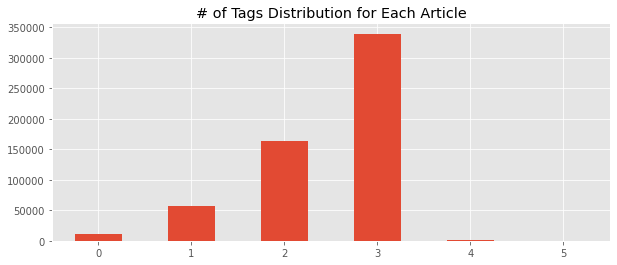

In [58]:

plt.figure(figsize=(10, 4))
metadata_core['keyword_list'].apply(lambda x: len(x)).value_counts(sort=False).plot(kind='bar', rot=0)
plt.title('# of Tags Distribution for Each Article')
plt.show()

글에 달 수 있는 태그는 최대 6개
태그 수가 대부분 2~3개
=> TF-IDF 벡터가 매우 sparse할 것 같다